In [1]:
import torch
import torchaudio
import PIL.Image
from IPython.display import Audio as play
from datasets import load_dataset, Audio
from torchvision.transforms.v2 import PILToTensor, ToPILImage

In [2]:
audioset20k = load_dataset("danjacobellis/audioset_opus_24kbps_balanced",split='train').cast_column('opus', Audio(decode=False))
imagenet1k = load_dataset('danjacobellis/imagenet_288_webp',split='train')

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/66 [00:00<?, ?it/s]

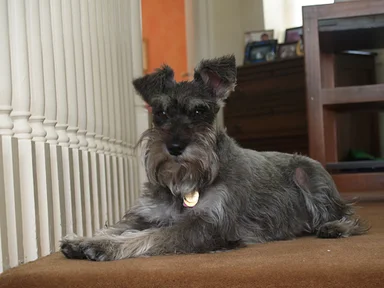

In [3]:
x_audio, fs = torchaudio.load(audioset20k[9]['opus']['bytes'],normalize=False);
assert x_audio.shape[1]==483840; assert fs==48000
assert x_audio.min() >= -1.0; assert x_audio.max() <= 1.0
display(play(x_audio, rate=fs))
x_image = PILToTensor()(imagenet1k[0]['webp'])/255 - 0.5
assert x_image.min() >= -1.0; assert x_image.max() <= 1.0
assert x_image.shape[0] == 3; assert x_image.shape[1] >= 288; assert x_image.shape[2] >= 288
display(ToPILImage()(x_image+0.5))

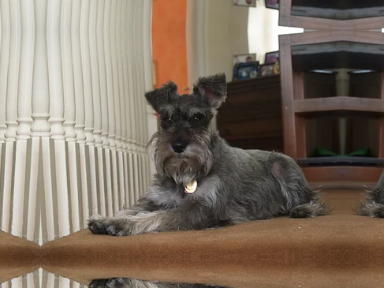

In [4]:
def shrink_1d(x, batch=False):
    if not batch:
        x = x.unsqueeze(0)
    ℓ = x.shape[2]
    s = 0.2*torch.rand(1).item()
    x = torch.nn.ReflectionPad1d(padding=int(ℓ*s))(x)
    x = torch.nn.functional.interpolate(x,ℓ,mode='linear')
    if not batch:
        x = x[0]
    return x

def shrink_2d(x, batch=False):
    if not batch:
        x = x.unsqueeze(0)
    h = x.shape[2]; w = x.shape[3]
    sh = 0.5*torch.rand(1).item(); T = int(h*sh)//2; B = int(h*sh) - T
    sw = 0.5*torch.rand(1).item(); L = int(w*sw)//2; R = int(w*sw) - L
    x = torch.nn.ReflectionPad2d(padding=(L,R,T,B))(x)
    x = torch.nn.functional.interpolate(x,(h,w),mode='bilinear')
    if not batch:
        x = x[0]
    return x
    
display(play(shrink_1d(x_audio), rate=fs))
display(ToPILImage()(shrink_2d(x_image)+0.5))

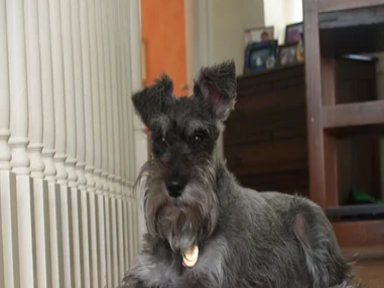

In [5]:
from torchvision.transforms.v2 import RandomCrop
def expand_1d(x, batch=False):
    if not batch:
        x = x.unsqueeze(0)
    ℓ = x.shape[2]
    s = 0.2*torch.rand(1).item()
    x = torch.nn.functional.interpolate(x,int(ℓ*(1+s)),mode='linear')
    x = RandomCrop((1,ℓ))(x.unsqueeze(1))[:,0]
    if not batch:
        x = x[0]
    return x

def expand_2d(x, batch=False):
    if not batch:
        x = x.unsqueeze(0)
    h = x.shape[2]; w = x.shape[3]
    sh = 0.5*torch.rand(1).item(); H = int(h*(1+sh))
    sw = 0.5*torch.rand(1).item(); W = int(w*(1+sw))
    x = torch.nn.functional.interpolate(x,(H,W),mode='bilinear')
    x = RandomCrop((h,w))(x)
    if not batch:
        x = x[0]
    return x
    
display(play(expand_1d(x_audio), rate=fs))
display(ToPILImage()(expand_2d(x_image)+0.5))

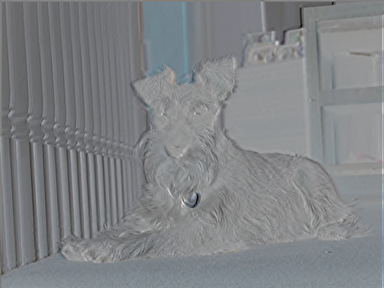

In [6]:
def filter_1d(x, batch=False):
    if not batch:
        x = x.unsqueeze(0)
    g = 2*torch.rand(5)-1
    g = torch.cat([g,torch.zeros(1),-g])
    g = g.view(1, 1, -1)
    B, C, L = x.shape
    x = torch.nn.functional.conv1d(
        x,
        weight=g.repeat(C, 1, 1),
        bias=None,
        stride=1,
        padding='same',
        groups=C
    )
    if not batch:
        x = x[0]
    return x


def filter_2d(x, batch=False):
    if not batch:
        x = x.unsqueeze(0)
    horizontal_filter = 0.2 + torch.rand(5)-0.5
    horizontal_filter = horizontal_filter.view(1, 1, 1, -1)
    vertical_filter = 0.2 + torch.rand(5)-0.5
    vertical_filter = vertical_filter.view(1, 1, -1, 1)
    B, C, H, W = x.shape
    x = torch.nn.functional.conv2d(
        x,
        weight=horizontal_filter.repeat(C, 1, 1, 1),
        bias=None,
        stride=1,
        padding='same',
        groups=C
    )
    x = torch.nn.functional.conv2d(
        x,
        weight=vertical_filter.repeat(C, 1, 1, 1),
        bias=None,
        stride=1,
        padding='same',
        groups=C
    )
    if not batch:
        x = x[0]
    return x
    
display(play(filter_1d(x_audio), rate=fs))
display(ToPILImage()(filter_2d(x_image).clamp(-0.5,0.5)+0.5))

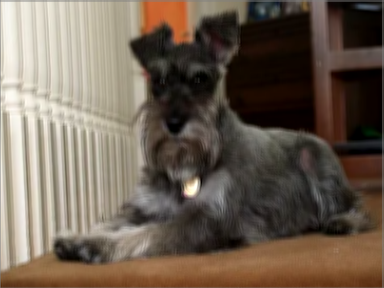

In [7]:
def aug(x, batch=False):
    if not batch:
        x = x.unsqueeze(0)
    if x.ndim == 3:
        operation = torch.randint(0, 2, (1,)).item()
        if operation == 0:
            x = shrink_1d(x, batch=True)
        else:
            x = expand_1d(x, batch=True)
        x = filter_1d(x, batch=True)
    elif x.ndim == 4:
        operation = torch.randint(0, 2, (1,)).item()
        if operation == 0:
            x = shrink_2d(x, batch=True)
        else:
            x = expand_2d(x, batch=True)
        x = filter_2d(x, batch=True)
    else:
        raise ValueError("Input tensor must have 3 (1D) or 4 (2D) dimensions.")
    if not batch:
        x = x[0]
    return x
display(play(aug(x_audio), rate=fs))
display(ToPILImage()(aug(x_image).clamp(-0.5, 0.5) + 0.5))